## Overview/To-Do

This simple example uses a reasonably bright GRB as both the training GRB and the simulated GRBs.  Lot's of things to do:

* Investigate different strength GRBs
* Investigate different detector numbers and layouts
* Investigate different detector sizes
    * Should be easy to do by changing the GRB signal strengths.
* Investigate multiple spacecraft
* Investigate different noise levels
* Calculate the physical flux that these count rates correspond to (depends on detector size)
* Spectral Studies (should still be able to do it fine with 8 x 8 detectors)
* What's the background for the measured counts.
* I'm sure there's more...

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
from BurstCube.LocSim.GRB import *
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from BurstCube.LocSim.Stats import calcNorms, addErrors, calcNormsWithError

/Users/jsperki1/.local/lib/python3.6/site-packages/BurstCube/data


## Set up
These are actually the default pointings but I put it here to show you how to set up various detectors.  I should add a detector 'size' at some point so that you can scale this better instead of via the counts of the GRB.


In [3]:
#Evenly spaced around azimuth
#Staggared 15 degree intervals from zenith
#Arbitrary type
pointings = {'01': ('0:0:0','5:0:0'),
            '02': ('30:0:0','20:0:0'),
            '03': ('60:0:0','35:0:0'),
            '04': ('90:0:0','10:0:0'),
            '05': ('120:0:0','25:0:0'),
            '06': ('150:0:0','40:0:0'),
            '07': ('180:0:0','15:0:0'),
            '08': ('210:0:0','30:0:0'),
            '09': ('240:0:0','45:0:0'),
            '10': ('270:0:0','20:0:0'),
            '11': ('300:0:0','35:0:0'),
            '12': ('330:0:0','50:0:0')}

Set up a spacecraft object with the pointings of the detector you've decided on.  The spacecraft defaults to a position above DC at an elevation of 550 km (about the orbit of Fermi).

In [4]:
spacecraft = Spacecraft(pointings,window=0.1)

In [5]:
spacecraft.detectors[0].zenith

0.08726646259971647

Set up some points in RA/Dec to calculate exposures and then access the 'exposure' function of the detector objects within the spacecraft object to plot the exposure.

In [6]:
NSIDE = 32
exposure_positions_hp = np.arange(hp.nside2npix(NSIDE))

In [7]:
exposure_positions_pix = hp.pix2ang(NSIDE, exposure_positions_hp, lonlat=True)

In [8]:
exposure_positions = np.vstack(exposure_positions_pix)

In [9]:
exposures = np.array([[ detector.exposure(position[0],position[1]) for position in exposure_positions.T] 
                      for detector in spacecraft.detectors])

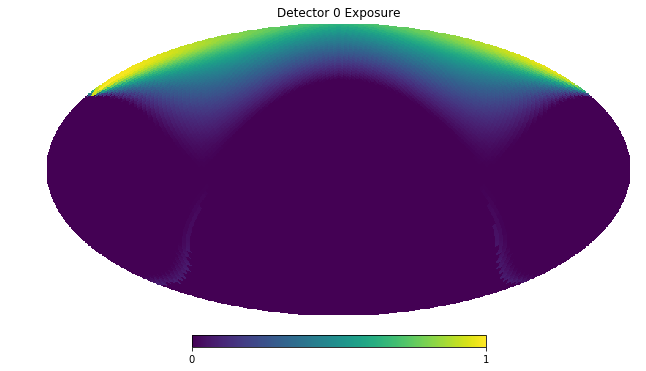

In [11]:
hp.mollview(exposures[0], max=1, title='Detector 0 Exposure')

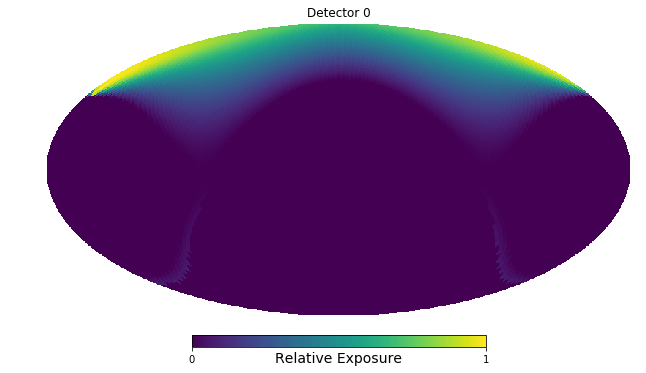

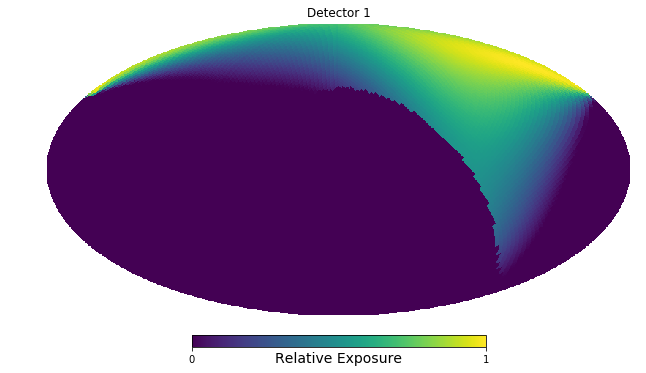

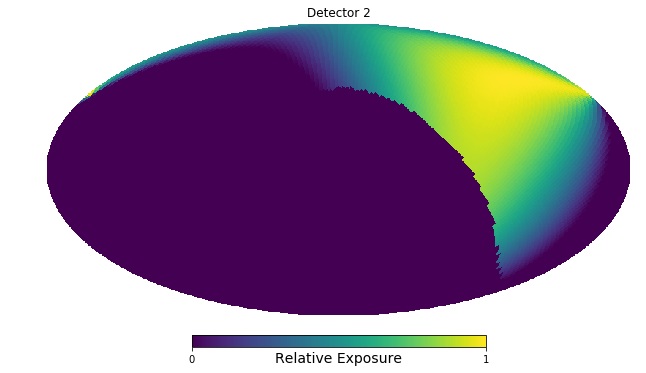

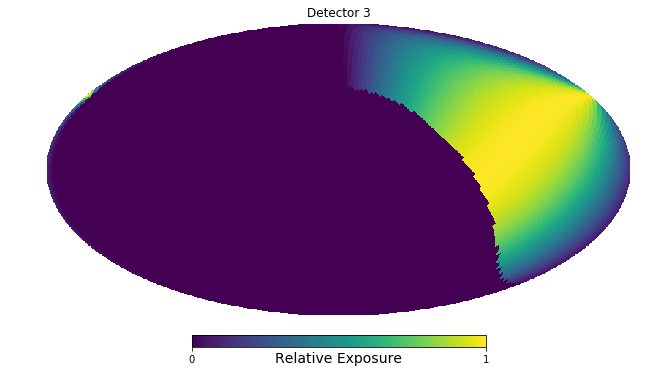

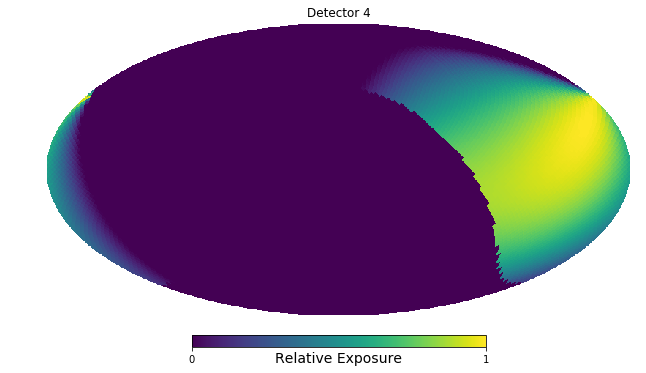

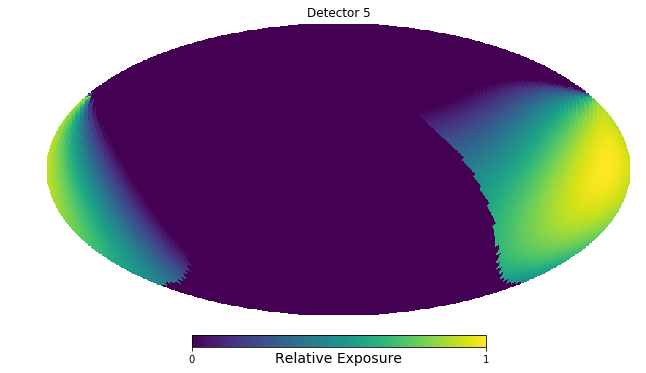

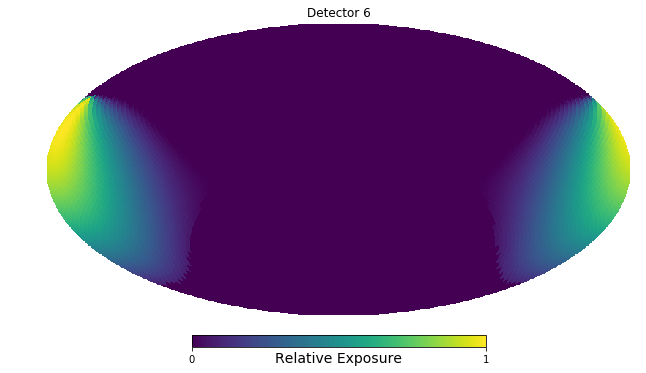

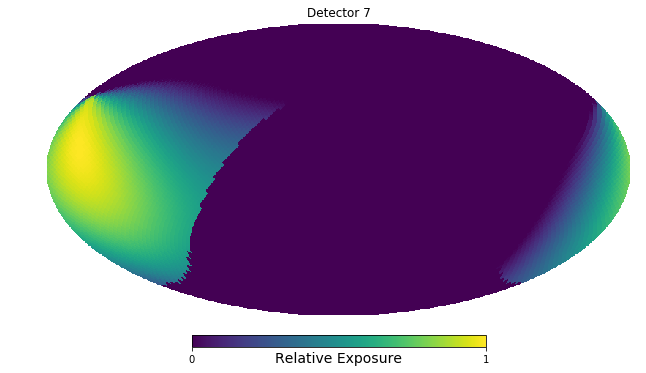

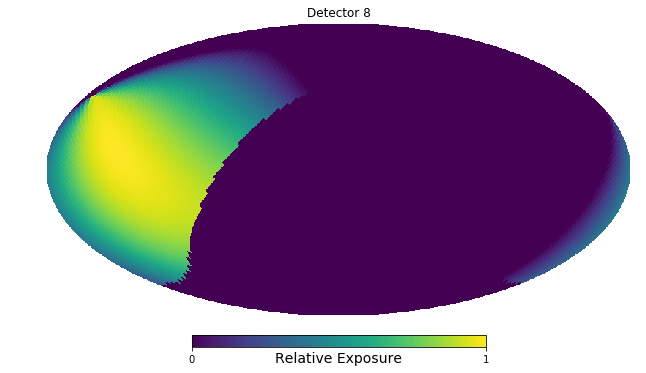

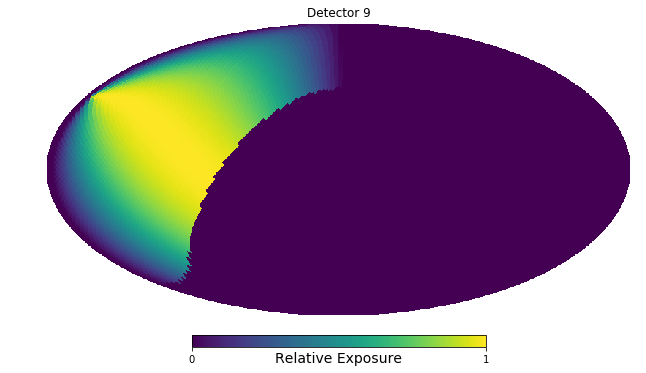

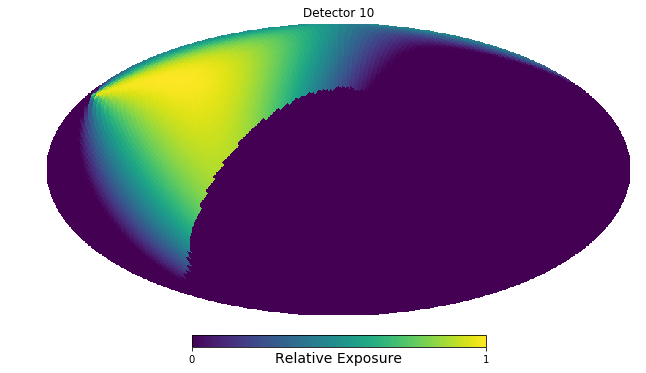

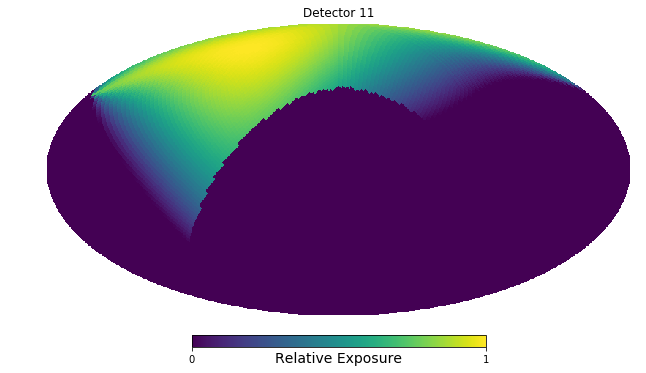

In [12]:
for sp in range(12):
    hp.mollview(exposures[sp], max=1, unit='Relative Exposure', 
                title='Detector {}'.format(sp))
    plt.show()

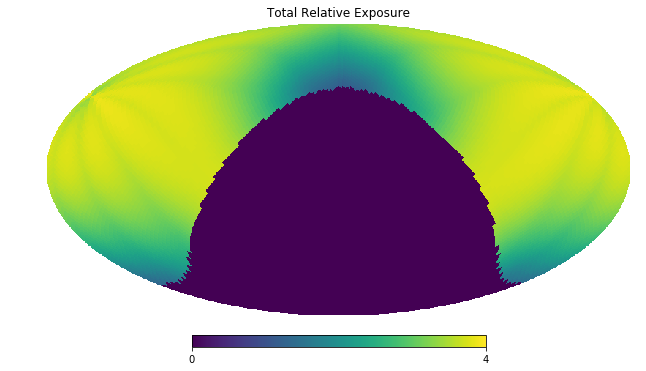

In [13]:
hp.mollview(exposures.sum(axis=0), max=4., title='Total Relative Exposure')

## Set up a training sample

Next, create a training sample in RA and Dec.  Create a GRB at each location in the sample.

Here, since our spacecraft is in the north, I'm only doing this in half of the sky (see the above exposure map).

In [14]:
NSIDE = 4
training_positions_hp = np.arange(hp.nside2npix(NSIDE))
training_positions_pix = hp.pix2ang(NSIDE, training_positions_hp, lonlat=True)
training_positions = np.vstack(training_positions_pix)

Cut out the ones with zero exposure due to the zenith angle cut.

In [15]:
exposures = np.array([[detector.exposure(position[0],position[1]) for position in training_positions.T] 
                      for detector in spacecraft.detectors])

In [16]:
training_grbs = [GRB(position[0],position[1],binz=.001) for position in training_positions.T[exposures.sum(axis=0) > 0.]]

Plot the separation from each GRB to each detector.  Doesn't look like it's perfectly uniform.

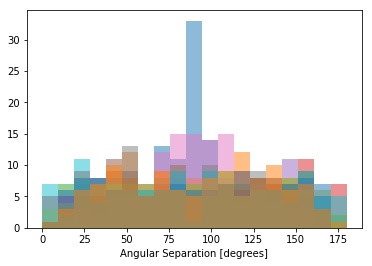

In [17]:
for detector in spacecraft.detectors:
    plt.hist([(180./np.pi)*detector.get_separation(grb) for grb in training_grbs],alpha=0.5,bins=np.linspace(0,180,20))
plt.xlabel('Angular Separation [degrees]')
plt.show()

Here are the locations of my training GRBs on the sky.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


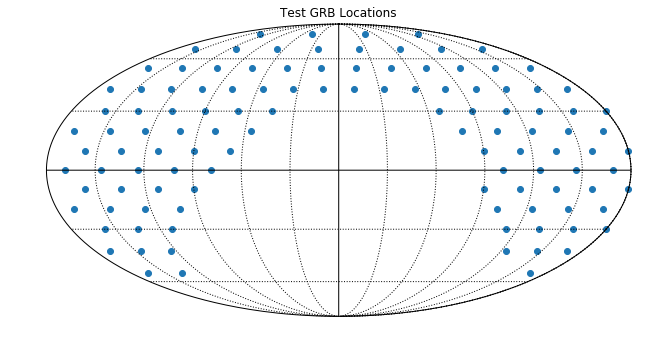

In [18]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in training_grbs])

hp.mollview(title="Test GRB Locations")
hp.graticule()
hp.projscatter(pos[:,0], pos[:,1], lonlat=True, coord='G')
plt.show()

## Throwing GRBs

This is an example of 'throwing' one of the GRBs on the sky and seeing what the detector sees.  I'll go into detail about what's happening under the hood below.  The error is just the sqrt of the counts.  

In [19]:
spacecraft.throw_grb(training_grbs[10])

[{'T0': 0.0,
  'counts': 20005,
  'counts_err': 141,
  'dec': 1.1596584621103643,
  'name': '01',
  'ra': 5.105088062083414},
 {'T0': 0.0,
  'counts': 33255,
  'counts_err': 182,
  'dec': 1.1596584621103643,
  'name': '02',
  'ra': 5.105088062083414},
 {'T0': 0.0,
  'counts': 32277,
  'counts_err': 180,
  'dec': 1.1596584621103643,
  'name': '03',
  'ra': 5.105088062083414},
 {'T0': 0.0,
  'counts': 17421,
  'counts_err': 132,
  'dec': 1.1596584621103643,
  'name': '04',
  'ra': 5.105088062083414},
 {'T0': -10.001,
  'counts': -1,
  'counts_err': -1,
  'dec': 1.1596584621103643,
  'name': '05',
  'ra': 5.105088062083414},
 {'T0': -10.001,
  'counts': -1,
  'counts_err': -1,
  'dec': 1.1596584621103643,
  'name': '06',
  'ra': 5.105088062083414},
 {'T0': -10.001,
  'counts': -1,
  'counts_err': -1,
  'dec': 1.1596584621103643,
  'name': '07',
  'ra': 5.105088062083414},
 {'T0': -10.001,
  'counts': -1,
  'counts_err': -1,
  'dec': 1.1596584621103643,
  'name': '08',
  'ra': 5.1050880620

Now that you've thrown a GRB at the spacecraft, each detector has a response to the GRB.  You can independently set the noise level of each detector if you wish or set a global one for the spacecraft.  Default is 10 counts.  Not all of the detectors will see each GRB.

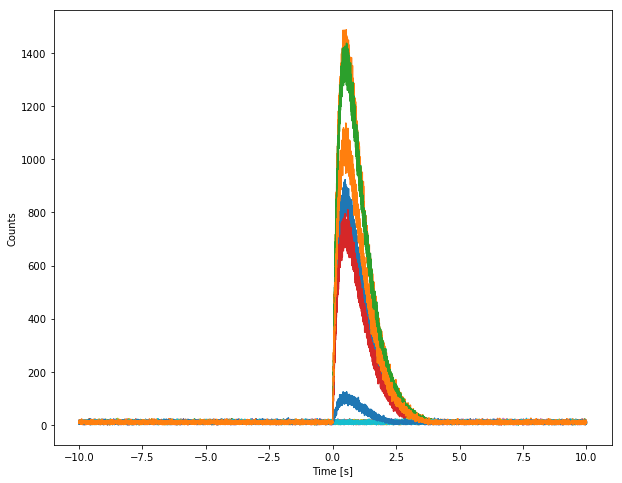

In [20]:
plt.figure(figsize=(10,8))
for detector in spacecraft.detectors:
    if np.sum(detector.response) > 0.:
        #plt.semilogy(detector.t,detector.response,label=detector.name)
        plt.plot(detector.t,detector.response)
plt.xlabel('Time [s]')
plt.ylabel('Counts')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig('Sample GRB.pdf', transparent = True)
plt.show()

The detectors have a significance curve for each which is how we can tell if that specific detector detected the GRB that was thrown at it.  The time window of this significance calculation can be set per detector or for the whole spacecraft.  Default is a 2 second window.  Note that the smallest time interval is 1 second.

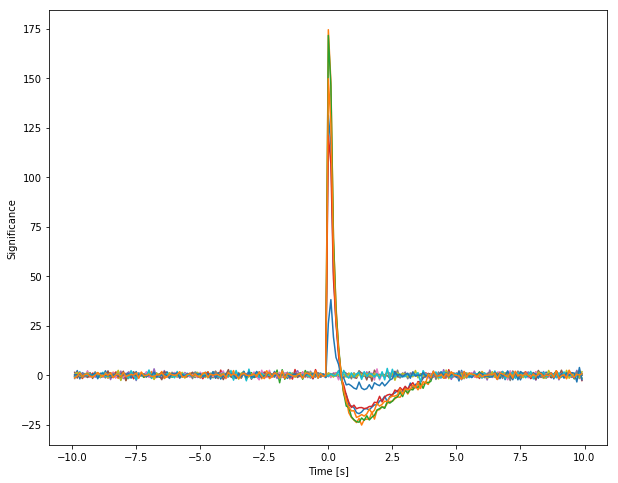

In [21]:
plt.figure(figsize=(10,8))
for detector in spacecraft.detectors:
    plt.plot(detector.sign_time,detector.significance,label=detector.name)
plt.xlabel('Time [s]')
plt.ylabel('Significance')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig('GRB Significance.pdf', transparent = True)
plt.show()

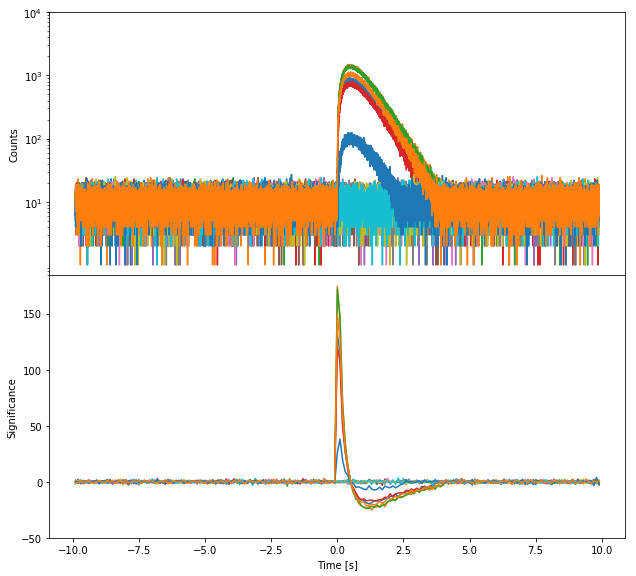

In [22]:
plt.figure(figsize=(10,10))
gs = mpl.gridspec.GridSpec(2,1)
gs.update(left=0.1,right=0.9,bottom=0.15, hspace=0.00, wspace=0.05)
ax1 = plt.subplot(gs[0,0])
for detector in spacecraft.detectors:
    if np.sum(detector.response) > 0.:
        ax1.semilogy(detector.response,label=detector.name)
ax1.yaxis.set_ticks(np.logspace(1,4,4))
ax1.xaxis.set_ticks([])
plt.ylabel('Counts')
ax2 = plt.subplot(gs[1,0])
for detector in spacecraft.detectors:
    ax2.plot(detector.sign_time,detector.significance,label=detector.name)
ax2.yaxis.set_ticks(np.linspace(-50,150,5))
plt.xlabel('Time [s]')
plt.ylabel('Significance')
plt.savefig('Sample GRB.pdf', transparent = True)
plt.show()

You can get at the detectors that saw the GRB and print out the name of that detector, the time it triggered (should all be '50 seconds' and the triggered count level.  The triggered counts are the sum of the counts in the trigger window (default is 2 seconds).

In [23]:
for detector in spacecraft.detectors:
    if detector.trigger_time > 0:
        print(detector.name,
              detector.trigger_time,
              detector.triggered_counts, 
              detector.triggered_counts_error)

01 10000 20005 141
02 10000 33255 182
03 10000 32277 180
04 10000 17421 132
11 10000 2498 50
12 10000 25192 159


## Throw all of the training GRBs

Note that we scale the counts in this case (as a percentage of the brightest detector).

In [ ]:
training_counts = spacecraft.throw_grbs(training_grbs,scaled=True)

## Setup and throw a random sample of GRBs

Note that I'm only throwing them in the north since the Earth blocks the south.

In [88]:
NSIDE = 128
real_positions_hp = np.random.choice(hp.nside2npix(NSIDE),100)
real_positions_pix = hp.pix2ang(NSIDE, real_positions_hp, lonlat=True)
real_positions = np.array(list(zip(real_positions_pix[0], real_positions_pix[1])))

In [91]:
exposures = np.array([[detector.exposure(position[0],position[1]) for position in real_positions]
                      for detector in spacecraft.detectors])

In [92]:
real_grbs = [GRB(position[0],position[1],binz=.001) for position in real_positions[exposures.sum(axis=0) > 0.]]

In [93]:
np.shape(real_grbs)

(61,)

In [94]:
real_counts = spacecraft.throw_grbs(real_grbs, scaled=True)

/Users/jsperki1/.local/lib/python3.6/site-packages/BurstCube/LocSim/Spacecraft.py:80: RuntimeWarning: invalid value encountered in true_divide
  for idx,rec in enumerate(grb_rec)]


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


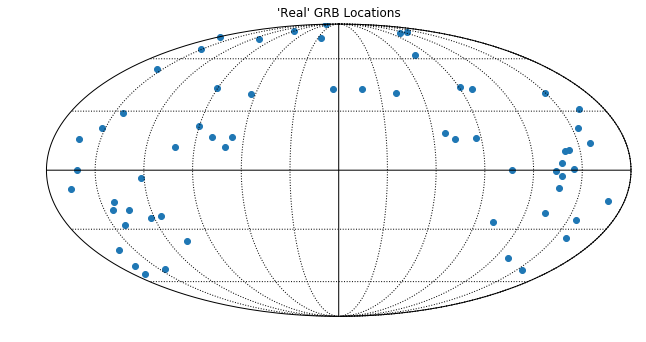

In [96]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in real_grbs])

hp.mollview(title="'Real' GRB Locations")
hp.graticule()
hp.projscatter(pos[:,0], pos[:,1], lonlat=True, coord='G')
plt.show()

## Find the most likely position of each random GRB

This just loops through every GRB in the lookup table and compares it to every GRB in the random sample.  Goal is to find the best match. Also should look at the statistical bounds of this.  This takes a bit so beware large samples.

Note that the statistical error is in the 1st column of the counts arrays and I'm adding (in quadrature) the statistical error from the training sample and the random sample to find the total error.  Then, I'm just doing a simpler +/- analysis to see what happens to the location.

In [97]:
norms = calcNorms(real_counts,training_counts)

In [98]:
real_counts_err = addErrors(real_counts,training_counts)

In [99]:
norms_errp, norms_errm = calcNormsWithError(real_counts,training_counts,real_counts_err)

Just to plot an example of one of these. 

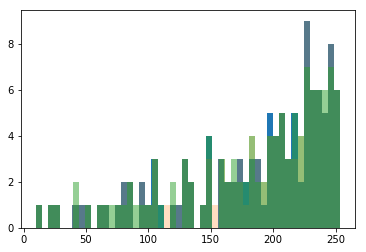

In [100]:
plt.hist(norms[6],bins=50,)
plt.hist(norms_errp[6],bins=50,alpha=0.25)
plt.hist(norms_errm[6],bins=50,alpha=0.5)
plt.show()

Find the minimum distance of each GRB.

In [101]:
loc_mins = [norm.argmin() for norm in norms]
loc_mins_errm = [norm.argmin() for norm in norms_errm]
loc_mins_errp = [norm.argmin() for norm in norms_errp]

Now, calculate the distance from the real GRB to the training one picked out from the distance measuremnt above.

In [102]:
errors = [eph.separation(grb.eph,training_grbs[loc_mins[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]
errors_errm = [eph.separation(grb.eph,training_grbs[loc_mins_errm[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]
errors_errp = [eph.separation(grb.eph,training_grbs[loc_mins_errp[idx]].eph)*180./np.pi for idx,grb in enumerate(real_grbs)]

Plot and save the cumulative distribution of this error.

[]

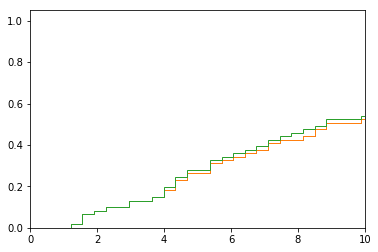

In [103]:
hist_data = plt.hist(errors,bins=100,normed=1, histtype='step', cumulative=True)
hist_data_errm = plt.hist(errors_errm,bins=100,normed=1, histtype='step', cumulative=True)
hist_data_errp = plt.hist(errors_errp,bins=100,normed=1, histtype='step', cumulative=True)
plt.xlim((0,10))
plt.plot()

The 1-sigma error is around 68%.  Quick function to find the distance value that most closely matches 0.68.

In [104]:
avg_stat = np.average([hist_data_errm[1][np.abs(hist_data_errm[0] - 0.68).argmin()],
                       hist_data_errp[1][np.abs(hist_data_errp[0] - 0.68).argmin()]])

In [105]:
print('Systematic Error: {:,.2f}'.format(hist_data[1][np.abs(hist_data[0] - 0.68).argmin()]))

Systematic Error: 11.27


In [106]:
print('Statistical Error: {:,.2f}'.format(avg_stat))

Statistical Error: 11.27


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


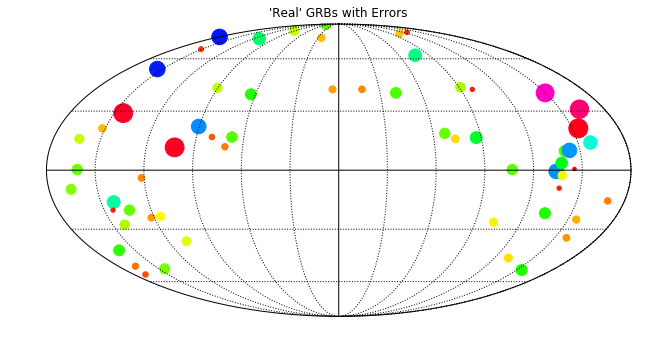

In [108]:
pos = np.array([[grb.eph._ra*180./np.pi,grb.eph._dec*180./np.pi] for grb in real_grbs])

hp.mollview(title="'Real' GRBs with Errors")
hp.graticule()
hp.projscatter(pos[:,0], pos[:,1], lonlat=True, coord='G', 
               c=errors, s=np.array(errors)*10, cmap=plt.cm.hsv)
plt.show()

[]

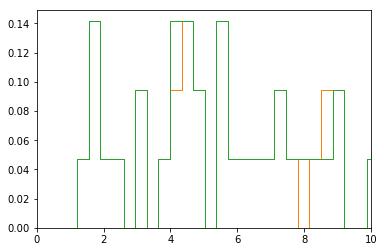

In [109]:
hist_data = plt.hist(errors,bins=100,normed=1, histtype='step')
hist_data_errm = plt.hist(errors_errm,bins=100,normed=1, histtype='step')
hist_data_errp = plt.hist(errors_errp,bins=100,normed=1, histtype='step')
plt.xlim((0,10))
plt.plot()